In [1]:
import os
try:
    from google.colab import drive
    COLAB = True
    print("Estoy en Google CoLab")
    %tensorflow_version 2.x
    !pip install livelossplot
except:
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    print("No estoy en Google CoLab")
    COLAB = False

No estoy en Google CoLab


In [ ]:
import tensorflow as tf
tf.__version__

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf

import imgaug
import imgaug.augmenters as iaa
import random
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from livelossplot import PlotLossesKerasTF
import cv2
import pandas as pd


# URL del dataset (ejemplo: imágenes de gatos y perros de Microsoft)
DATASET_URL = "/Users/sergiosantiago/developments/master/AP/S6/FacialExpressionDS"

# Descargar y extraer automáticamente
dataset_path = tf.keras.utils.get_file(
    "FacialExpressionDS.zip", 
    origin=DATASET_URL, 
    extract=True
)


# La función lo guarda en `~/.keras/datasets/`
dataset_dir = dataset_path.replace(".zip", "")  # Carpeta donde se extrajo
dataset_dir = "/Users/sergiosantiago/developments/master/AP/S6/FacialExpressionDS"

# Cargar imágenes desde el directorio
image_size = (96, 96)  # Ajustar según el dataset
batch_size = 32

# Define el mapeo de etiquetas
labels_map = {
    '0': 'Anger',
    '1': 'Contempt',
    '2': 'Disgust',
    '3': 'Fear',
    '4': 'Happy',
    '5': 'Neutral',
    '6': 'Sad',
    '7': 'Surprise'
}


In [3]:
class ImageSequence(Sequence):
    def __init__(self, dataset_dir, batch_size=32, shuffle=True, label_filter=[], return_ids=False, data_pct=1):
        self.label_filter = label_filter
        self.image_dir = os.path.join(dataset_dir, "images")
        self.label_dir = os.path.join(dataset_dir, "labels")
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_size = (96, 96)  # Tamaño de imagen
        self.file_names = sorted(os.listdir(self.image_dir))  # Nombres de archivos de imágenes
        
        if data_pct < 1:
            random.shuffle(self.file_names)
            self.file_names = self.file_names[:int(len(self.file_names)*data_pct)]
        
        self.return_ids = return_ids
        
        if len(label_filter) > 0:
            filtered_list = []
            for file_name in self.file_names:
                label_path = os.path.join(self.label_dir, file_name.replace(os.path.splitext(file_name)[1], ".txt"))
                
                with open(label_path, "r") as f:
                    label = int(f.read().strip()[0])   # Leer el primer carácter y convertir a int
                    
                if label in label_filter:
                    filtered_list.append(file_name)
                    
            self.file_names = filtered_list
        
        
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        self.on_epoch_end()  # Mezclar si es necesario
        
        
        
        self.__read_images = {}

    def __len__(self):
        """Número de lotes por época"""
        return int(np.floor(len(self.file_names) / self.batch_size))

    def __getitem__(self, index):
        """Obtiene un lote de datos"""
        batch_files = self.file_names[index * self.batch_size:(index + 1) * self.batch_size]
        images, labels, ids = self.__data_generation(batch_files)
        if ids is not None:
            return np.array(images), np.array(labels), ids
        else:
            return np.array(images), np.array(labels)

    def on_epoch_end(self):
        """Mezcla los datos al final de cada época"""
        if self.shuffle:
            np.random.shuffle(self.file_names)

    def __data_generation(self, batch_files):
        """Carga imágenes, detecta la cara y asigna etiquetas"""
        images, labels = [], []
        
        augseq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.GammaContrast((0.5, 2.0)),
            iaa.Affine(scale=(1.0, 1.5)),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
        ])
        
        ids = []
        for file_name in batch_files:
            # Cargar imagen en escala de grises para detección de cara
            img_path = os.path.join(self.image_dir, file_name)
            
            if img_path not in self.__read_images:
                img_bgr = cv2.imread(img_path)  # OpenCV carga en BGR
                img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

                # Detectar cara
                faces = self.face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

                if len(faces) > 0:
                    x, y, w, h = faces[0]  # Tomamos la primera cara detectada
                    face_crop = img_bgr[y:y+h, x:x+w]  # Recortar cara
                else:
                    face_crop = img_bgr  # Si no hay cara, usar la imagen completa

                # Redimensionar a 96x96 y normalizar
                face_resized = cv2.resize(face_crop, self.image_size)
                face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)  # Convertir a RGB
                
                img_array = face_rgb
                self.__read_images[img_path] = face_rgb
            else:
                img_array = self.__read_images[img_path] 
                
            img_array = augseq(images=[img_array])[0]
            img_array = img_array / 255.0  # Normalizar                
            images.append(img_array)
            
            ids.append(file_name)

            # Cargar etiqueta desde el archivo de texto correspondiente
            label_path = os.path.join(self.label_dir, file_name.replace(os.path.splitext(file_name)[1], ".txt"))
            with open(label_path, "r") as f:
                label = int(f.read().strip()[0])   # Leer el primer carácter y convertir a int
                
            if len(self.label_filter) > 0:
                label = self.label_filter.index(label)
            labels.append(label)
        
        if self.return_ids:
            return np.array(images), np.array(labels), ids
        else:
            return np.array(images), np.array(labels), None


In [5]:
train_gen = ImageSequence(os.path.join(dataset_dir, 'FacialExpressionDS/train'), label_filter=[4,5,6,7])
batch = train_gen[0]
batch[0][0], batch[1][0]

(array([[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.46666667, 0.32941176, 0.16078431],
         [0.4745098 , 0.33333333, 0.16470588],
         [0.47843137, 0.3372549 , 0.16862745]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.45098039, 0.31372549, 0.14901961],
         [0.45490196, 0.31764706, 0.15294118],
         [0.45882353, 0.32156863, 0.15294118]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.43137255, 0.29803922, 0.14117647],
         [0.42745098, 0.29411765, 0.1372549 ],
         [0.42745098, 0.29803922, 0.1372549 ]],
 
        ...,
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.     

Clases detectadas: ['Happy', 'Neutral', 'Sad', 'Surprise']


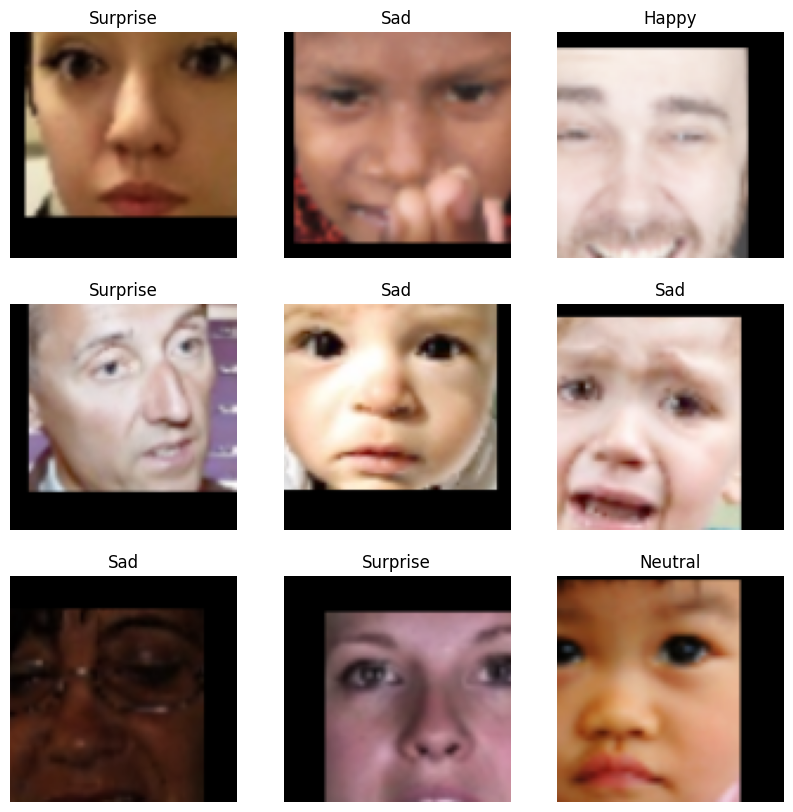

In [6]:
class_names = list(labels_map.values())
class_names = [class_names[i] for i in [4,5,6,7]]
print(f"Clases detectadas: {class_names}")

# Mostrar algunas imágenes del dataset
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(batch[0], batch[1])):
    plt.subplot(3, 3, i + 1)
    plt.imshow( (image * 255).astype("uint8"))
    plt.title(class_names[int(label)])
    plt.axis("off")
    if i >=8:
        break
plt.show()


In [8]:
# 1. Definir Parámetros
IMG_SIZE = (96, 96)  # Tamaño estándar para AlexNet
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 4  # Número de categorías de expresiones faciales
DATASET_DIR = dataset_dir 

# ---------------------------
# Cargar y Preprocesar Datos
# ---------------------------
train_gen = ImageSequence(os.path.join(dataset_dir, 'FacialExpressionDS/train'), label_filter=[4,5,6,7])

val_gen =  ImageSequence(os.path.join(dataset_dir, 'FacialExpressionDS/valid'), label_filter=[4,5,6,7])

test_gen = ImageSequence(os.path.join(dataset_dir, 'FacialExpressionDS/test'), label_filter=[4,5,6,7])


# -------------------------------
# Leemos el modelo pre-entrenado 
# con las categorías anteriores
# -------------------------------


# Podeis descargarlo de:
#     https://hdvirtual.us.es/discovirt/index.php/s/bgAW86WWDatzytY
#
# descomprimir en el directorio del notebook

model = tf.keras.models.load_model('last_model.h5')


# ---------------------------
# Evaluar en datos de test
# ---------------------------
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n🔹 Precisión en test: {test_acc:.2%}")


/Users/sergiosantiago/developments/master/AP/S6/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.6943 - loss: 0.8102

🔹 Precisión en test: 70.35%


#### Usar el modelo con una categoría más (0 == Anger)

In [10]:
train_gen = ImageSequence(os.path.join(dataset_dir, 'FacialExpressionDS/train'), label_filter=[0,4,5,6,7])

val_gen =  ImageSequence(os.path.join(dataset_dir, 'FacialExpressionDS/valid'), label_filter=[0,4,5,6,7])

In [ ]:
preds = []
Y = []
for x, y in train_gen:
    p = model.predict(x)
    Y += list(Y)
    
    preds.append(Y)
    
preds = np.vstack(preds)
Y = np.array(preds)

####  Preparación del archivo de soluciones

In [13]:
sol_template = pd.read_csv('solution_template.csv')
sol_template['Target'] = None

test_gen = ImageSequence(os.path.join(dataset_dir, 'FacialExpressionDS/test'), label_filter=[0,4,5,6,7], 
                         return_ids=True, batch_size=2000, shuffle=False)

preds = []
Y = []
IDS = []
x, _, id_ = test_gen[0]
p = model.predict(x)

for i, t in zip(id_, p):
    if t.max() < thresold:
        t = 0
    else:
        t = t.argmax() + 1
    sol_template.loc[sol_template.ID == i, 'Target'] = t

print(sol_template.Target.isnull().sum())

sol_template.to_csv('subm_base.csv', index=False)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


NameError: name 'thresold' is not defined

## Transferencia de conocimiento

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

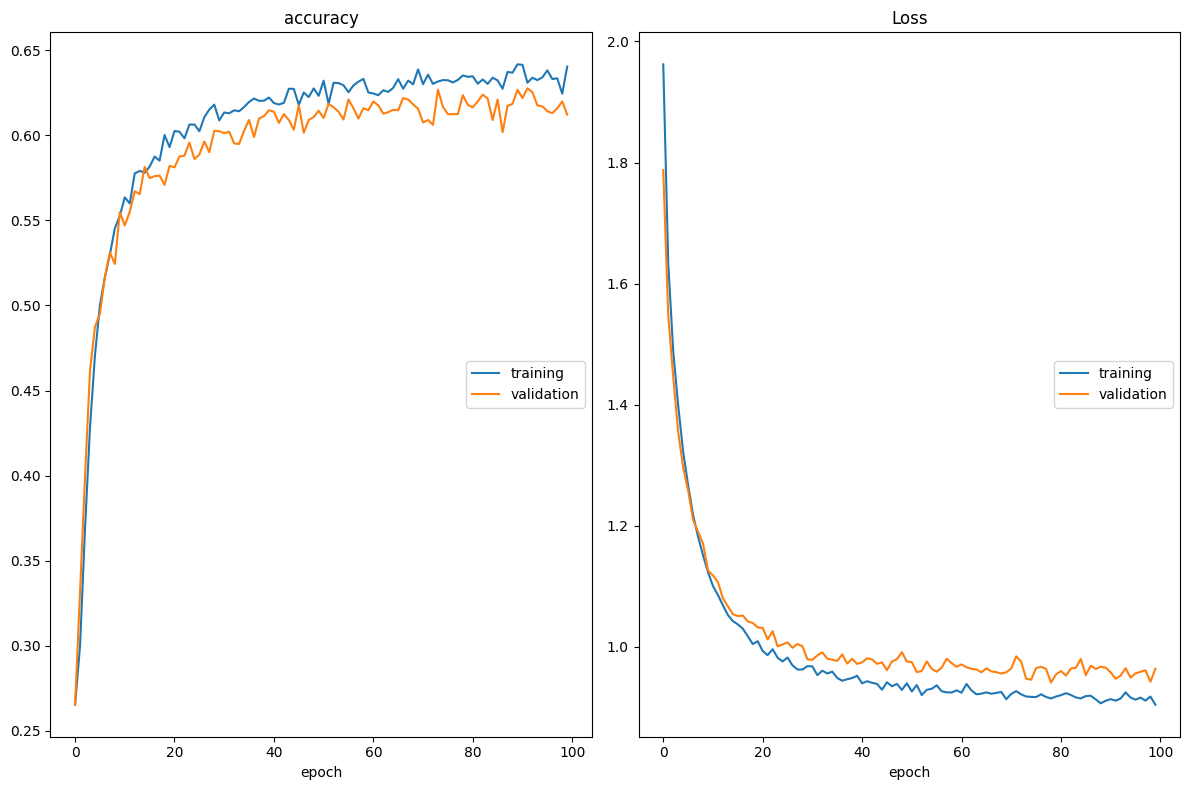

accuracy
	training         	 (min:    0.265, max:    0.642, cur:    0.640)
	validation       	 (min:    0.265, max:    0.628, cur:    0.612)
Loss
	training         	 (min:    0.904, max:    1.962, cur:    0.904)
	validation       	 (min:    0.941, max:    1.788, cur:    0.964)
338/338 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.6351 - loss: 0.9108 - val_accuracy: 0.6121 - val_loss: 0.9639


In [15]:
## Crear un nuevo modelo quitando solamente la última capa 
## y agregando una nueva capa con una neurona más.
## Todas las capas del modelo, menos la última debe quedar
## congeladas.

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

model.trainable = False
x = model.layers[-2].output
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=model.inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


### Modificando capas

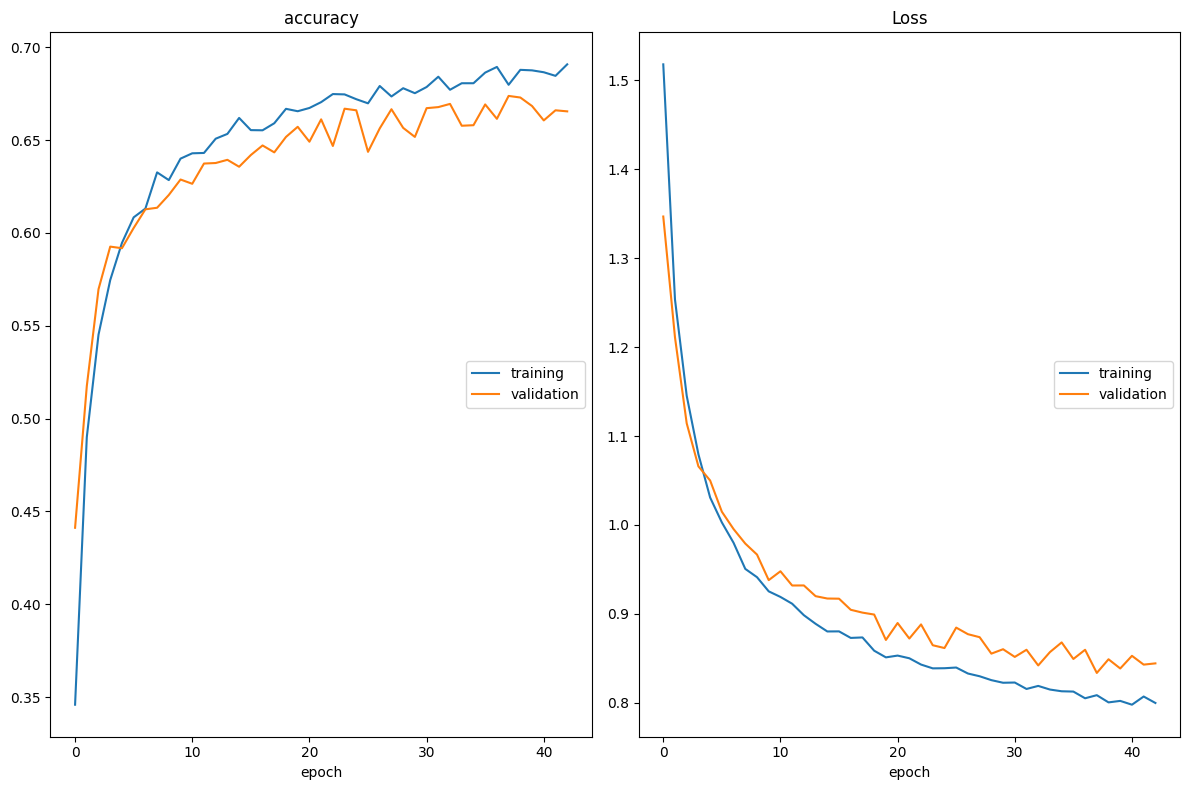

accuracy
	training         	 (min:    0.346, max:    0.691, cur:    0.691)
	validation       	 (min:    0.441, max:    0.674, cur:    0.665)
Loss
	training         	 (min:    0.798, max:    1.518, cur:    0.800)
	validation       	 (min:    0.834, max:    1.347, cur:    0.844)
338/338 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6987 - loss: 0.7846 - val_accuracy: 0.6654 - val_loss: 0.8443


In [18]:
model = tf.keras.models.load_model('last_model.h5')

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

for layer in model.layers[:-4]:
    layer.trainable = False
    
x = model.layers[-2].output
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=model.inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

### Entrenando de cero

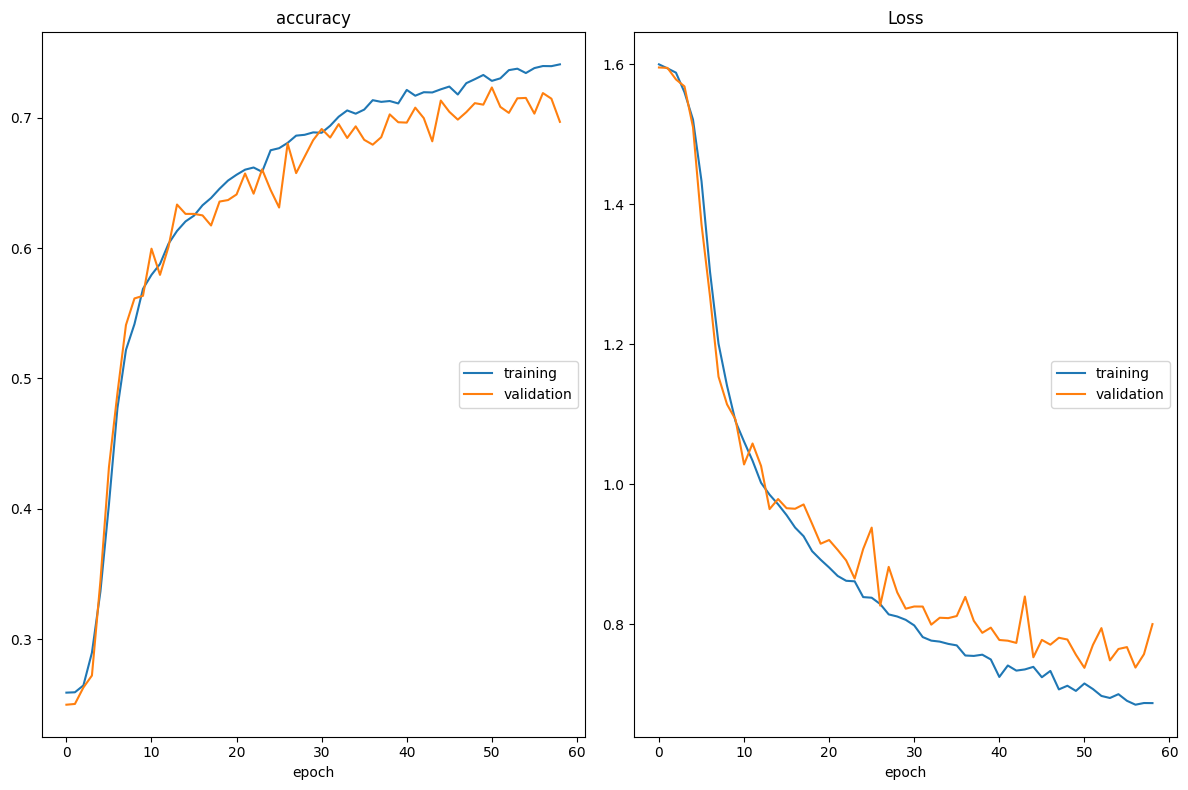

accuracy
	training         	 (min:    0.259, max:    0.741, cur:    0.741)
	validation       	 (min:    0.250, max:    0.723, cur:    0.697)
Loss
	training         	 (min:    0.685, max:    1.600, cur:    0.688)
	validation       	 (min:    0.738, max:    1.596, cur:    0.800)
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 104ms/step - accuracy: 0.7463 - loss: 0.6721 - val_accuracy: 0.6967 - val_loss: 0.8004


In [21]:
from datetime import datetime
from tensorflow.keras import layers, Model, Input, regularizers
time = datetime.now()
print(time)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ModelCheckpoint("last_model_4.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

inputs = Input(shape=(96, 96, 3))

x = layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same", name='conv1')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same", name='conv2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same", name='conv3', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same", name='conv4', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.MaxPooling2D()(x)
last_conv = layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same", name='last_conv')(x)
x = layers.MaxPooling2D()(last_conv)
global_avg = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES+1, activation='softmax')(global_avg)

model_81 = Model(inputs=inputs, outputs=outputs)

print(model_81.summary())


# Compilar el Modelo
model_81.compile(optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model_81.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    )



In [ ]:
# ---------------------------
# Evaluar en Datos de Validación
# ---------------------------
test_loss, test_acc = model_81.evaluate(test_gen)
print(f"\n🔹 Precisión en test: {test_acc:.2%}")

### InceptionResNetV2 sin reentrenar capas anteriores y sin añadir nuevas

In [23]:
from keras.applications import InceptionResNetV2

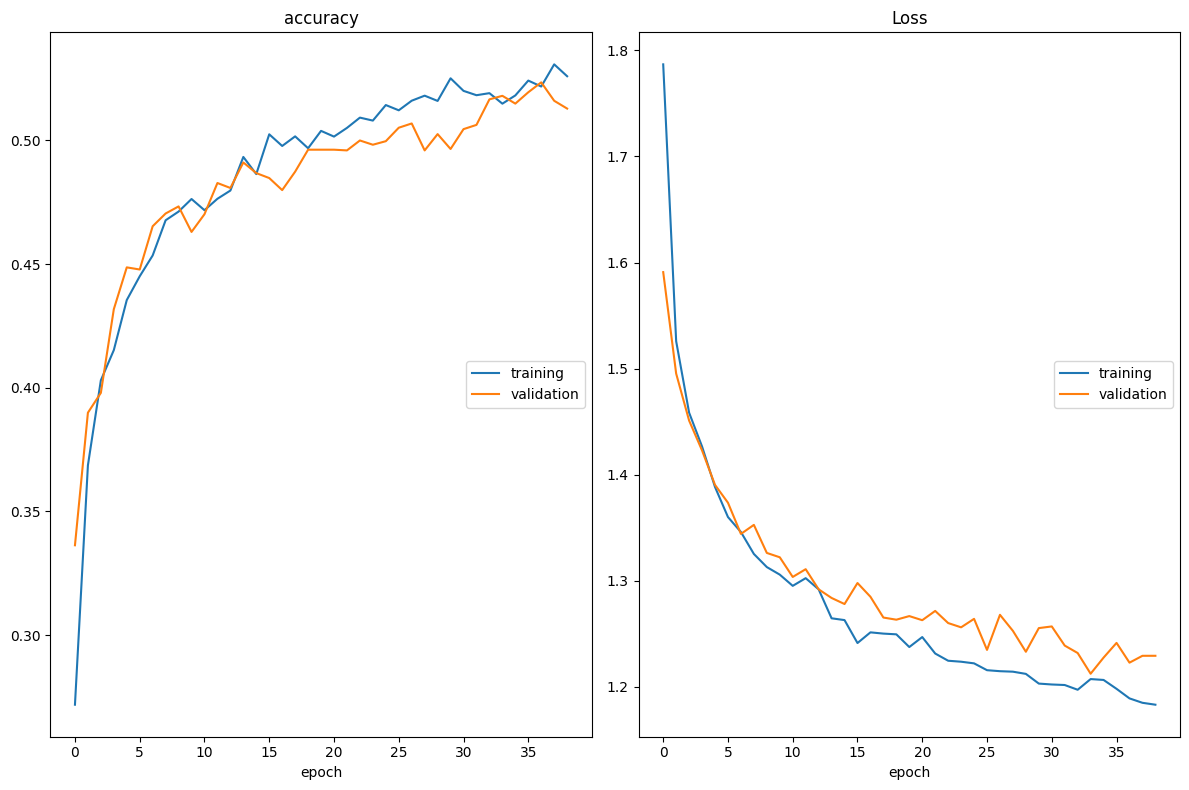

accuracy
	training         	 (min:    0.272, max:    0.531, cur:    0.526)
	validation       	 (min:    0.336, max:    0.524, cur:    0.513)
Loss
	training         	 (min:    1.183, max:    1.787, cur:    1.183)
	validation       	 (min:    1.212, max:    1.591, cur:    1.229)
338/338 ━━━━━━━━━━━━━━━━━━━━ 71s 210ms/step - accuracy: 0.5300 - loss: 1.1720 - val_accuracy: 0.5129 - val_loss: 1.2292


In [30]:
inputs = Input(shape=(96, 96, 3))

base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

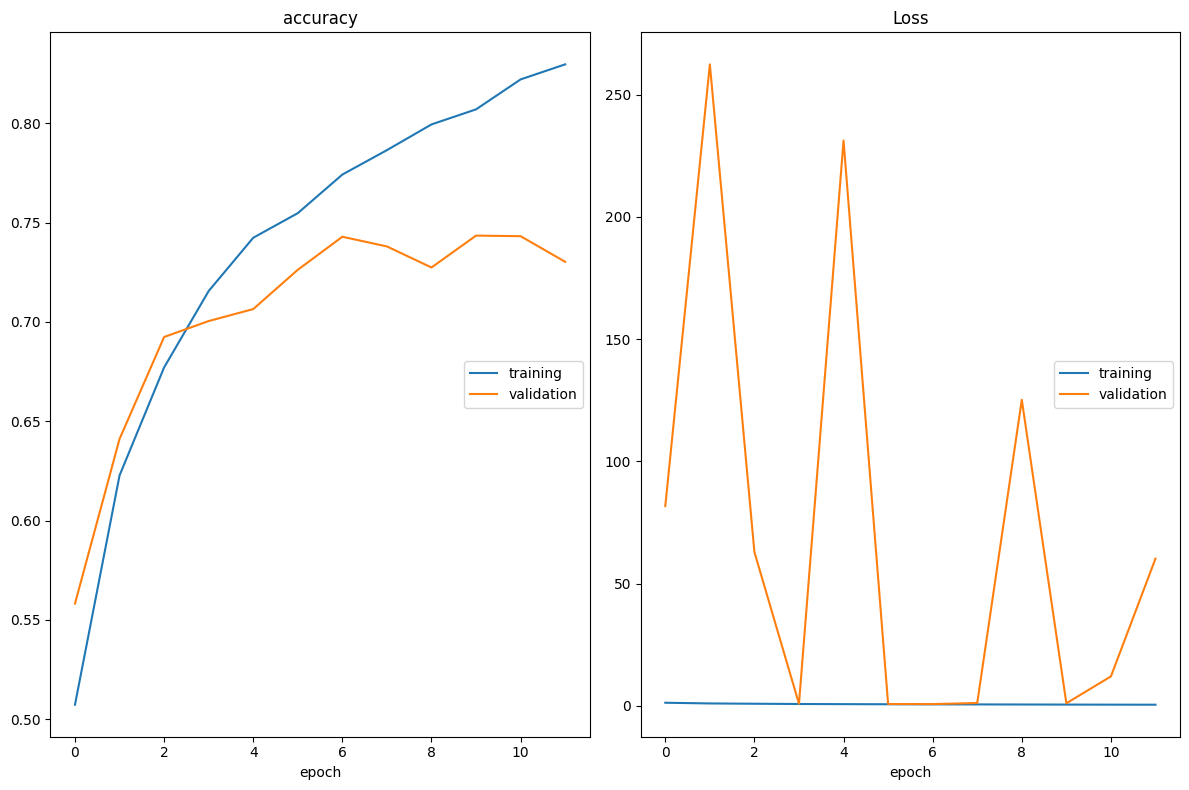

accuracy
	training         	 (min:    0.507, max:    0.830, cur:    0.830)
	validation       	 (min:    0.558, max:    0.743, cur:    0.730)
Loss
	training         	 (min:    0.448, max:    1.250, cur:    0.448)
	validation       	 (min:    0.699, max:  262.372, cur:   60.197)
338/338 ━━━━━━━━━━━━━━━━━━━━ 255s 752ms/step - accuracy: 0.8326 - loss: 0.4407 - val_accuracy: 0.7302 - val_loss: 60.1969


In [31]:
inputs = Input(shape=(96, 96, 3))

base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_3.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

for layer in base_model.layers[:-3]:
    layer.trainable = True

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

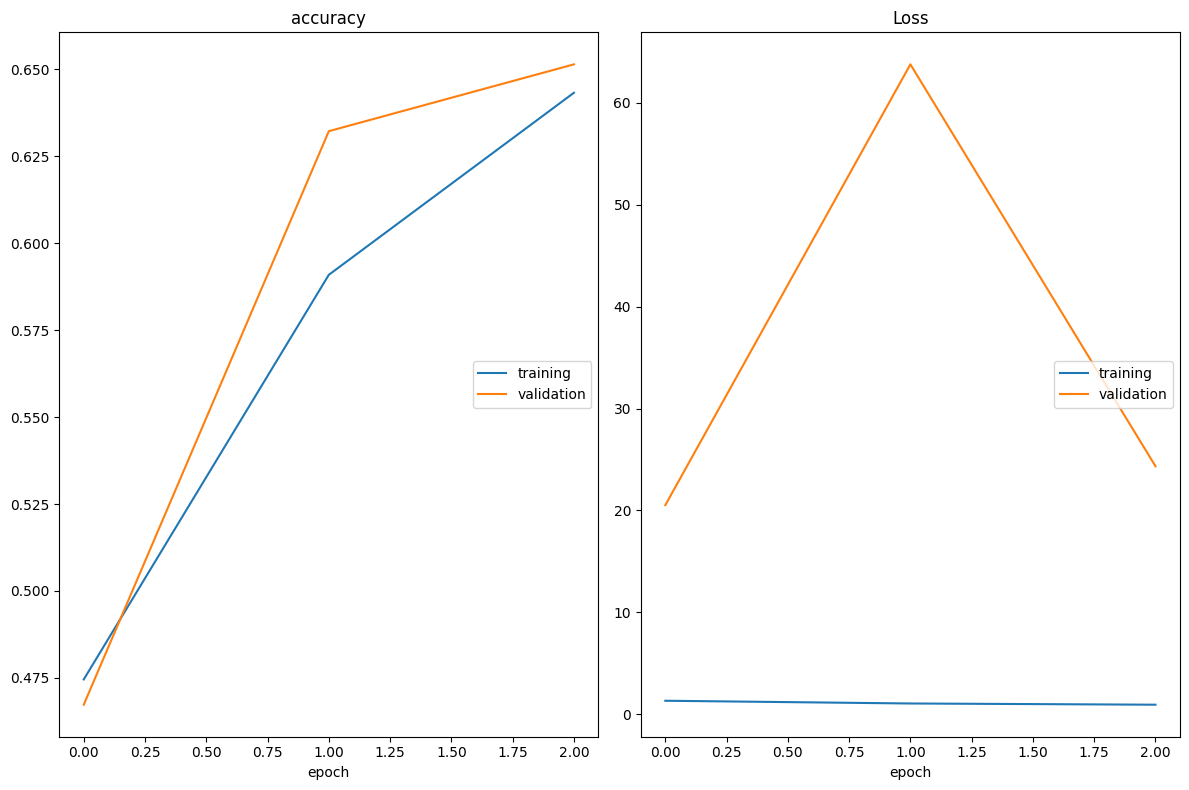

accuracy
	training         	 (min:    0.475, max:    0.643, cur:    0.643)
	validation       	 (min:    0.467, max:    0.651, cur:    0.651)
Loss
	training         	 (min:    0.925, max:    1.314, cur:    0.925)
	validation       	 (min:   20.513, max:   63.786, cur:   24.332)
338/338 ━━━━━━━━━━━━━━━━━━━━ 257s 761ms/step - accuracy: 0.6437 - loss: 0.9397 - val_accuracy: 0.6514 - val_loss: 24.3320
Epoch 4/100
226/338 ━━━━━━━━━━━━━━━━━━━━ 1:22 732ms/step - accuracy: 0.6904 - loss: 0.8164

In [57]:
inputs = Input(shape=(96, 96, 3))

base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_2.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

for layer in base_model.layers[:-3]:
    layer.trainable = True

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

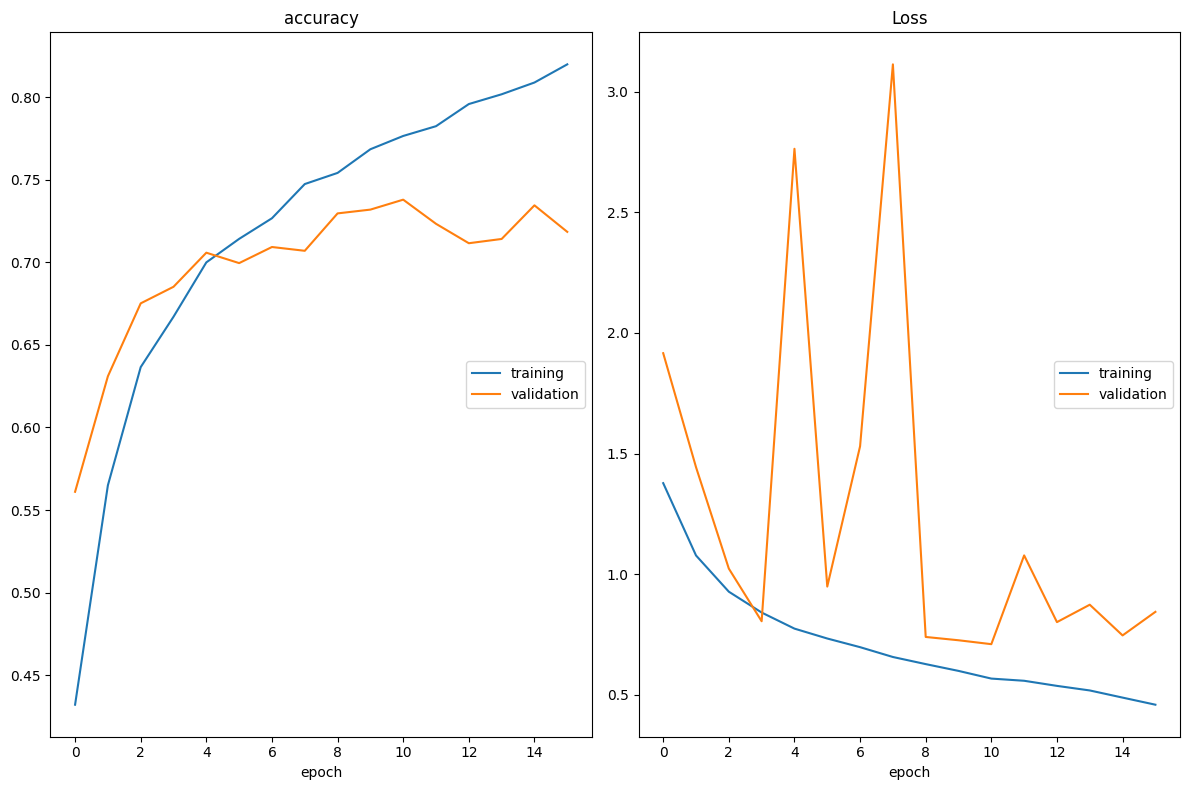

accuracy
	training         	 (min:    0.432, max:    0.820, cur:    0.820)
	validation       	 (min:    0.561, max:    0.738, cur:    0.718)
Loss
	training         	 (min:    0.460, max:    1.377, cur:    0.460)
	validation       	 (min:    0.710, max:    3.113, cur:    0.844)
338/338 ━━━━━━━━━━━━━━━━━━━━ 245s 726ms/step - accuracy: 0.8202 - loss: 0.4492 - val_accuracy: 0.7185 - val_loss: 0.8443


In [56]:
inputs = Input(shape=(96, 96, 3))

base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_1.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

for layer in base_model.layers[:-3]:
    layer.trainable = True

x = base_model(inputs)

x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

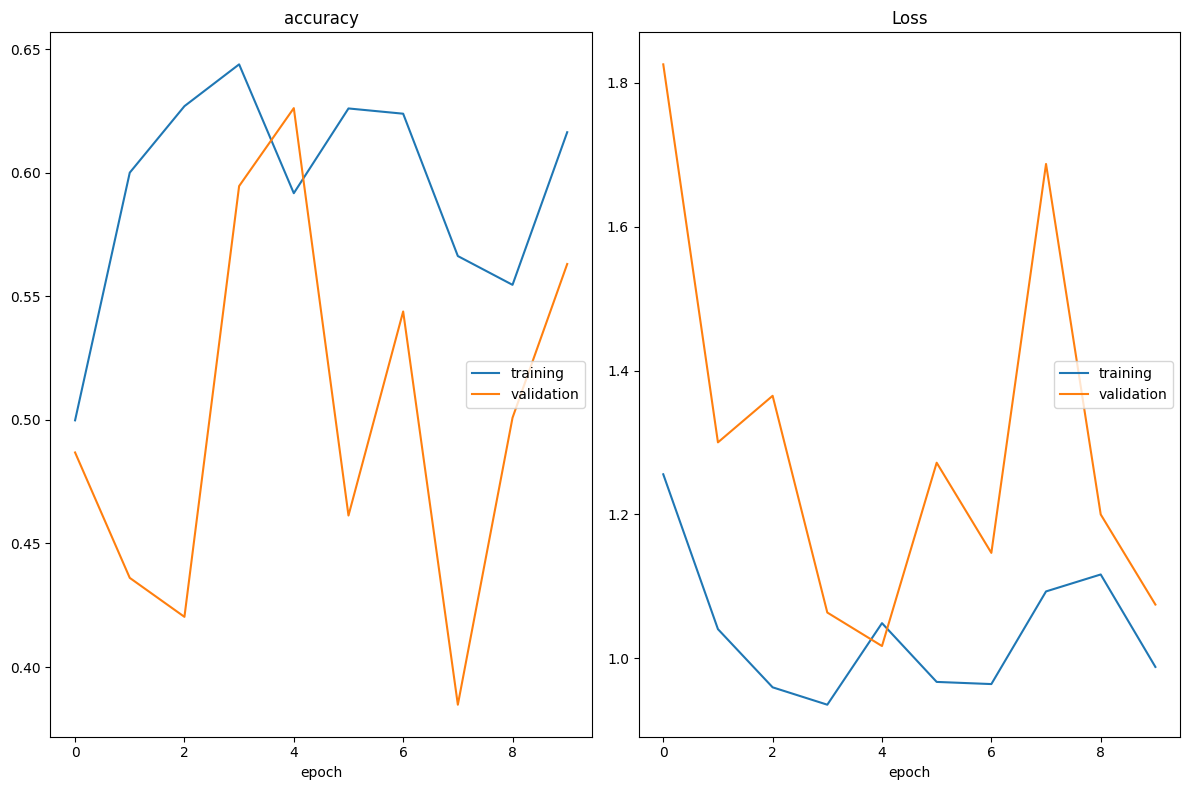

accuracy
	training         	 (min:    0.500, max:    0.644, cur:    0.616)
	validation       	 (min:    0.385, max:    0.626, cur:    0.563)
Loss
	training         	 (min:    0.935, max:    1.256, cur:    0.988)
	validation       	 (min:    1.017, max:    1.826, cur:    1.075)
338/338 ━━━━━━━━━━━━━━━━━━━━ 244s 723ms/step - accuracy: 0.5958 - loss: 1.0168 - val_accuracy: 0.5631 - val_loss: 1.0747


In [41]:
inputs = Input(shape=(96, 96, 3))

base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

for layer in base_model.layers[:-3]:
    layer.trainable = True

x = base_model(inputs)
x = layers.SpatialDropout2D(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

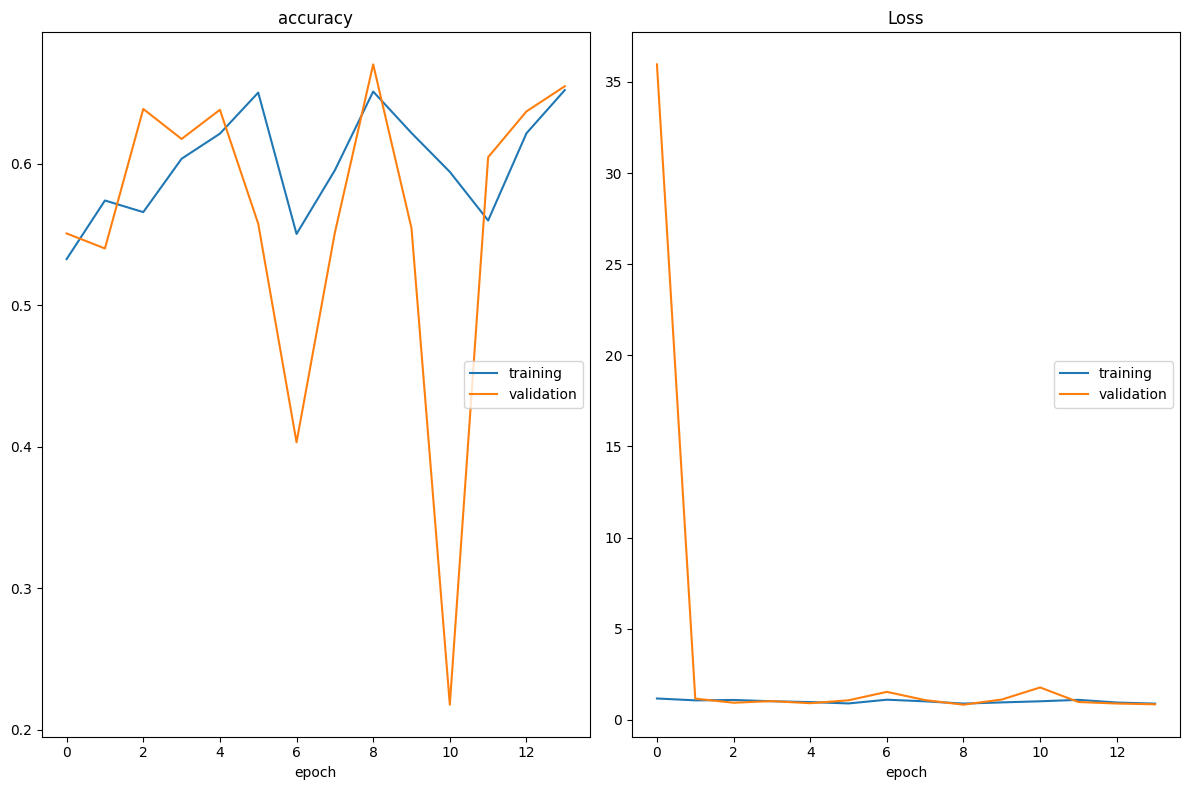

accuracy
	training         	 (min:    0.533, max:    0.652, cur:    0.652)
	validation       	 (min:    0.218, max:    0.670, cur:    0.655)
Loss
	training         	 (min:    0.890, max:    1.171, cur:    0.890)
	validation       	 (min:    0.830, max:   35.967, cur:    0.853)
338/338 ━━━━━━━━━━━━━━━━━━━━ 247s 730ms/step - accuracy: 0.6474 - loss: 0.9053 - val_accuracy: 0.6548 - val_loss: 0.8526


In [42]:
inputs = Input(shape=(96, 96, 3))

base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

for layer in base_model.layers[:-3]:
    layer.trainable = True

x = base_model(inputs)

x = layers.Flatten()(x)

x2 = layers.Dense(32, activation="relu")(x)
x2 = layers.Dropout(0.2)(x2)

x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

x = layers.Concatenate()([x, x2])

x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

In [43]:
from keras.applications import VGG16

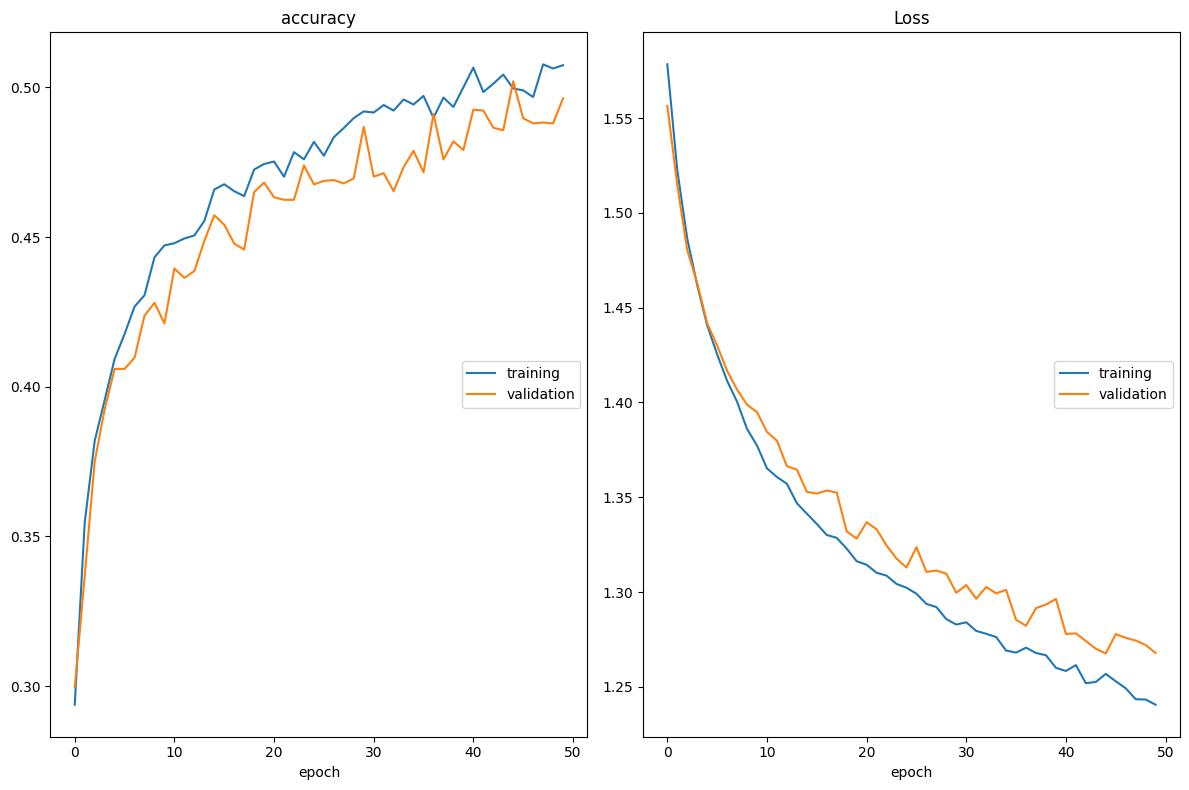

accuracy
	training         	 (min:    0.294, max:    0.508, cur:    0.507)
	validation       	 (min:    0.300, max:    0.502, cur:    0.496)
Loss
	training         	 (min:    1.241, max:    1.578, cur:    1.241)
	validation       	 (min:    1.268, max:    1.556, cur:    1.268)
338/338 ━━━━━━━━━━━━━━━━━━━━ 160s 474ms/step - accuracy: 0.5115 - loss: 1.2391 - val_accuracy: 0.4963 - val_loss: 1.2679


In [44]:
inputs = Input(shape=(96, 96, 3))

base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_VGG16.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

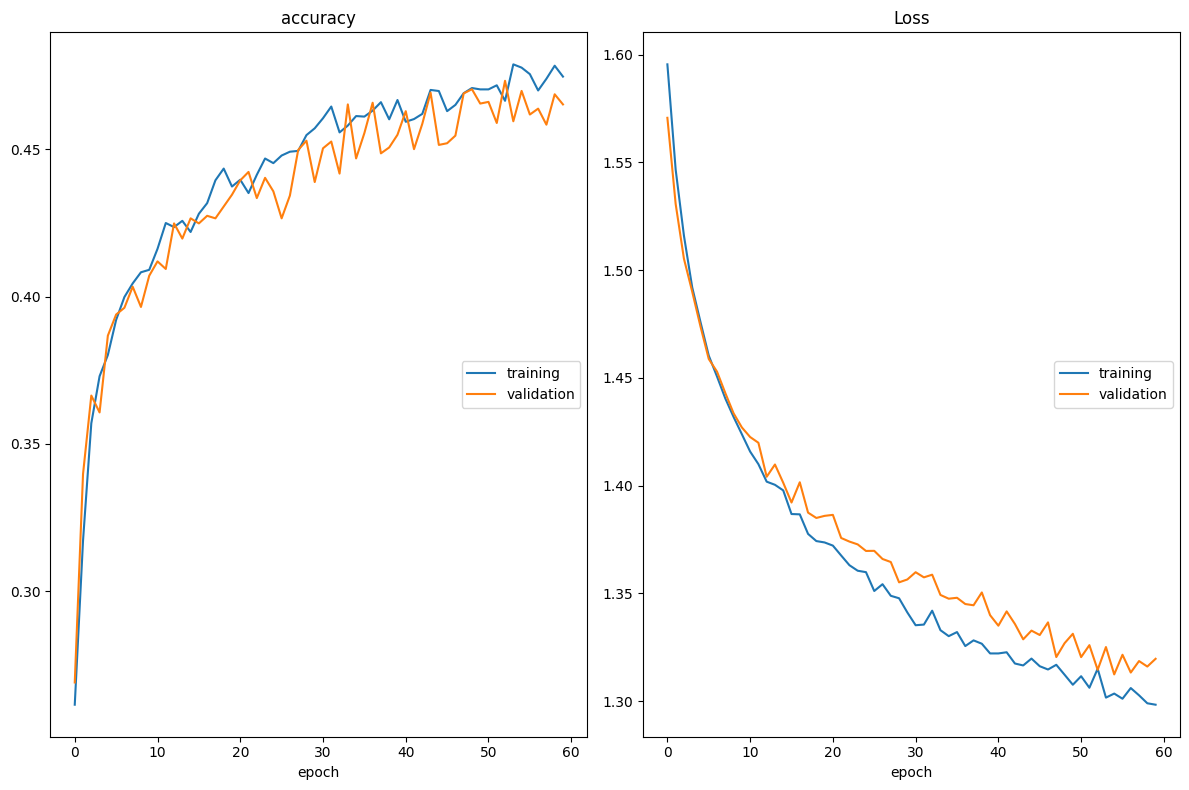

accuracy
	training         	 (min:    0.261, max:    0.479, cur:    0.475)
	validation       	 (min:    0.269, max:    0.473, cur:    0.465)
Loss
	training         	 (min:    1.298, max:    1.596, cur:    1.298)
	validation       	 (min:    1.312, max:    1.571, cur:    1.320)
338/338 ━━━━━━━━━━━━━━━━━━━━ 196s 581ms/step - accuracy: 0.4794 - loss: 1.2917 - val_accuracy: 0.4653 - val_loss: 1.3196


In [45]:
from keras.applications import VGG19

inputs = Input(shape=(96, 96, 3))

base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_VGG19.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

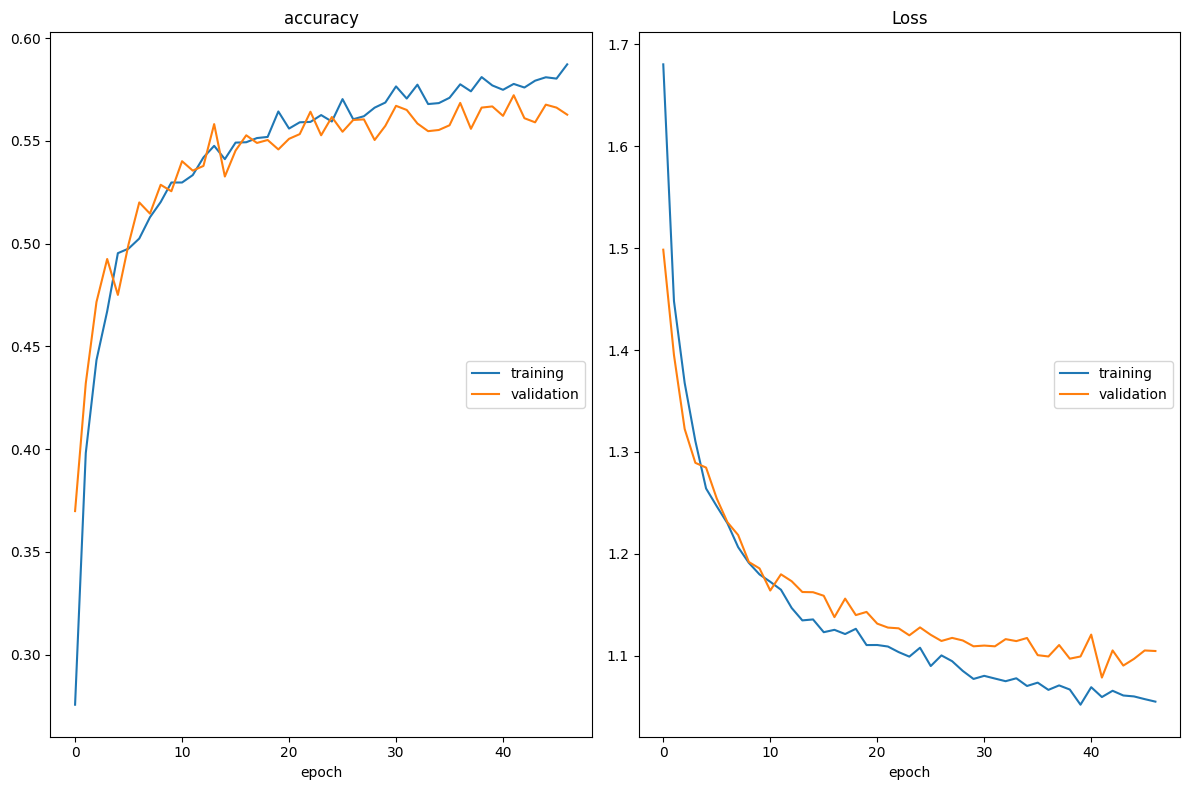

accuracy
	training         	 (min:    0.276, max:    0.587, cur:    0.587)
	validation       	 (min:    0.370, max:    0.572, cur:    0.563)
Loss
	training         	 (min:    1.052, max:    1.680, cur:    1.055)
	validation       	 (min:    1.079, max:    1.498, cur:    1.105)
338/338 ━━━━━━━━━━━━━━━━━━━━ 103s 304ms/step - accuracy: 0.5810 - loss: 1.0673 - val_accuracy: 0.5628 - val_loss: 1.1047


In [46]:
from keras.applications import DenseNet201

inputs = Input(shape=(96, 96, 3))

base_model = DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_DenseNet201.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

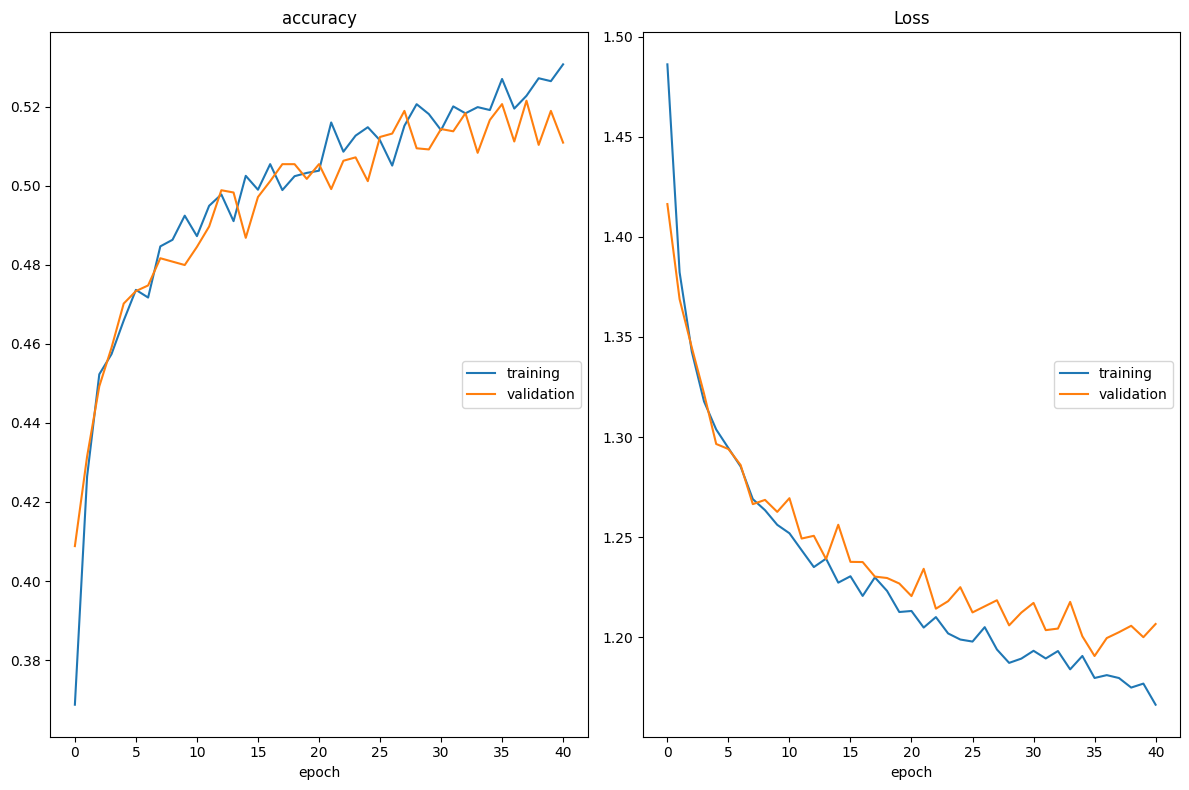

accuracy
	training         	 (min:    0.369, max:    0.531, cur:    0.531)
	validation       	 (min:    0.409, max:    0.522, cur:    0.511)
Loss
	training         	 (min:    1.166, max:    1.486, cur:    1.166)
	validation       	 (min:    1.191, max:    1.416, cur:    1.207)
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 174ms/step - accuracy: 0.5321 - loss: 1.1588 - val_accuracy: 0.5109 - val_loss: 1.2067


In [47]:
from keras.applications import Xception

inputs = Input(shape=(96, 96, 3))

base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_Xception.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

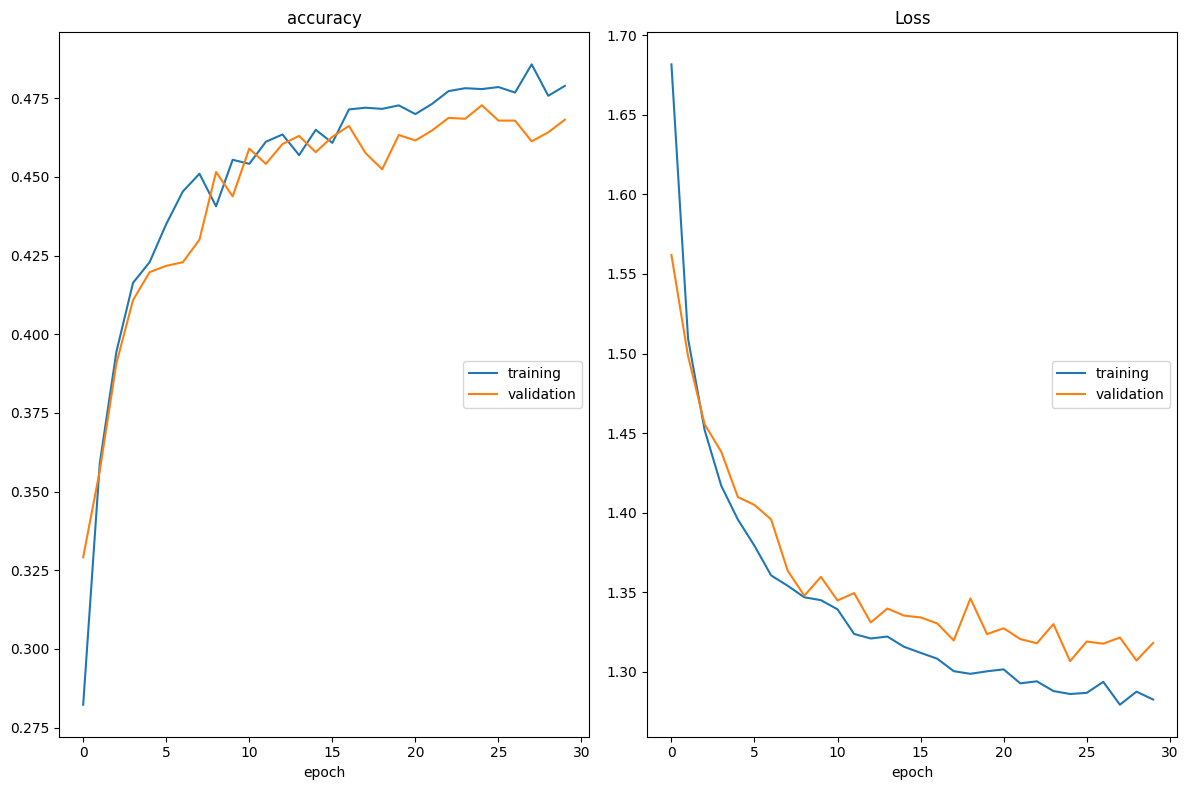

accuracy
	training         	 (min:    0.282, max:    0.486, cur:    0.479)
	validation       	 (min:    0.329, max:    0.473, cur:    0.468)
Loss
	training         	 (min:    1.279, max:    1.682, cur:    1.282)
	validation       	 (min:    1.307, max:    1.562, cur:    1.318)
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.4723 - loss: 1.2902 - val_accuracy: 0.4682 - val_loss: 1.3181


In [48]:
from keras.applications import InceptionV3

inputs = Input(shape=(96, 96, 3))

base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_InceptionV3.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

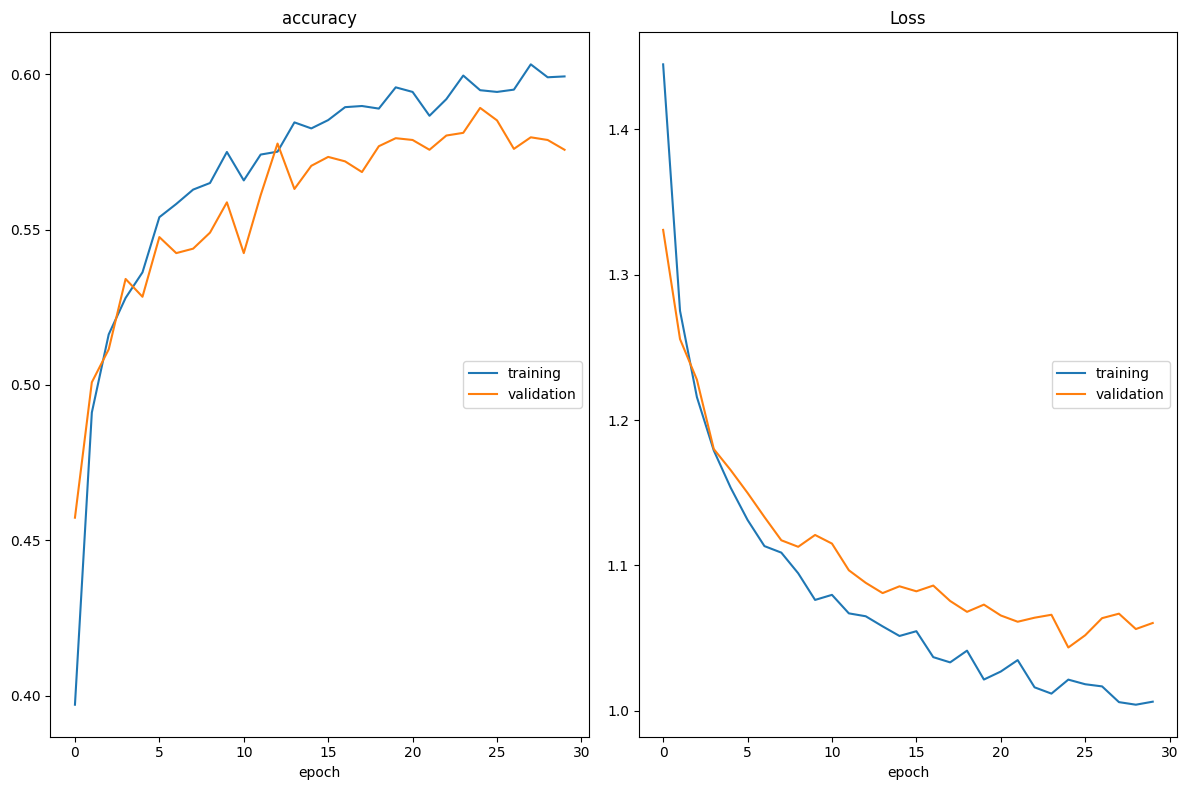

accuracy
	training         	 (min:    0.397, max:    0.603, cur:    0.599)
	validation       	 (min:    0.457, max:    0.589, cur:    0.576)
Loss
	training         	 (min:    1.004, max:    1.445, cur:    1.006)
	validation       	 (min:    1.044, max:    1.331, cur:    1.060)
338/338 ━━━━━━━━━━━━━━━━━━━━ 158s 466ms/step - accuracy: 0.5986 - loss: 1.0094 - val_accuracy: 0.5757 - val_loss: 1.0604


In [49]:
inputs = Input(shape=(96, 96, 3))

base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_VGG16.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

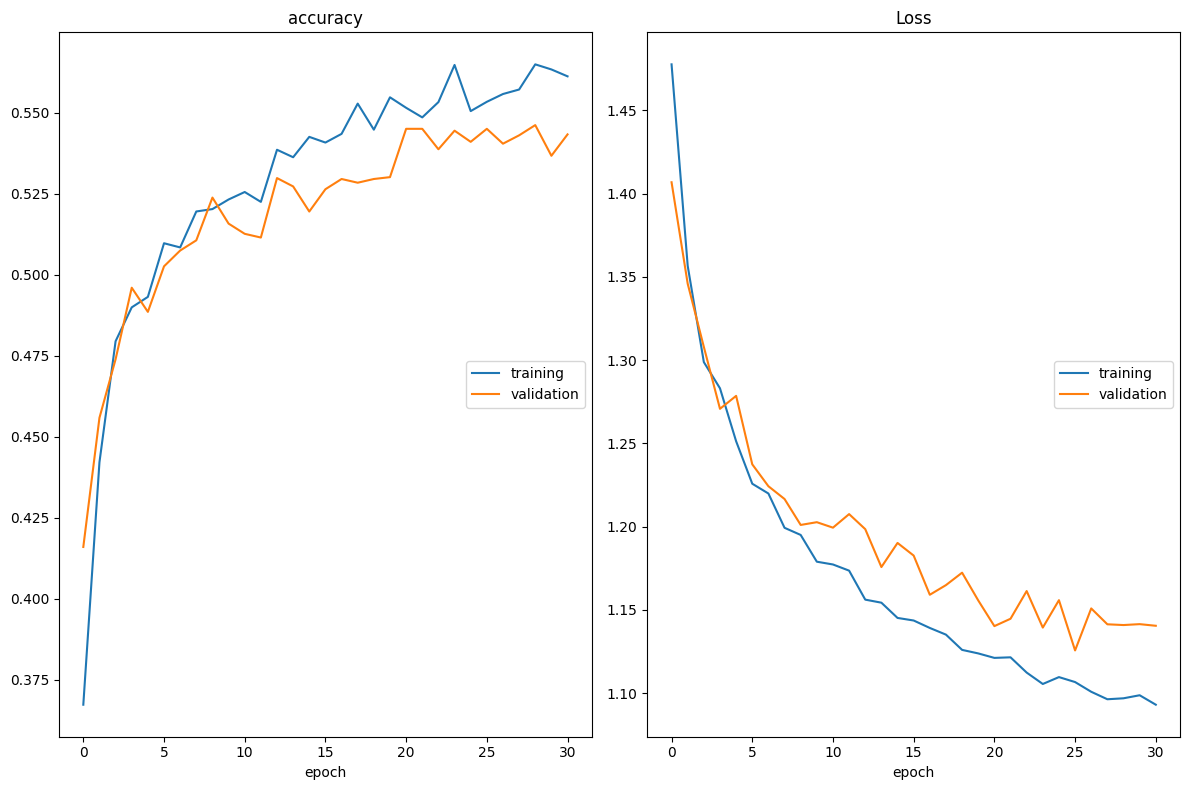

accuracy
	training         	 (min:    0.367, max:    0.565, cur:    0.561)
	validation       	 (min:    0.416, max:    0.546, cur:    0.543)
Loss
	training         	 (min:    1.093, max:    1.478, cur:    1.093)
	validation       	 (min:    1.126, max:    1.407, cur:    1.140)
338/338 ━━━━━━━━━━━━━━━━━━━━ 201s 596ms/step - accuracy: 0.5589 - loss: 1.0982 - val_accuracy: 0.5433 - val_loss: 1.1405


In [50]:
from keras.applications import VGG19

inputs = Input(shape=(96, 96, 3))

base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_VGG19.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

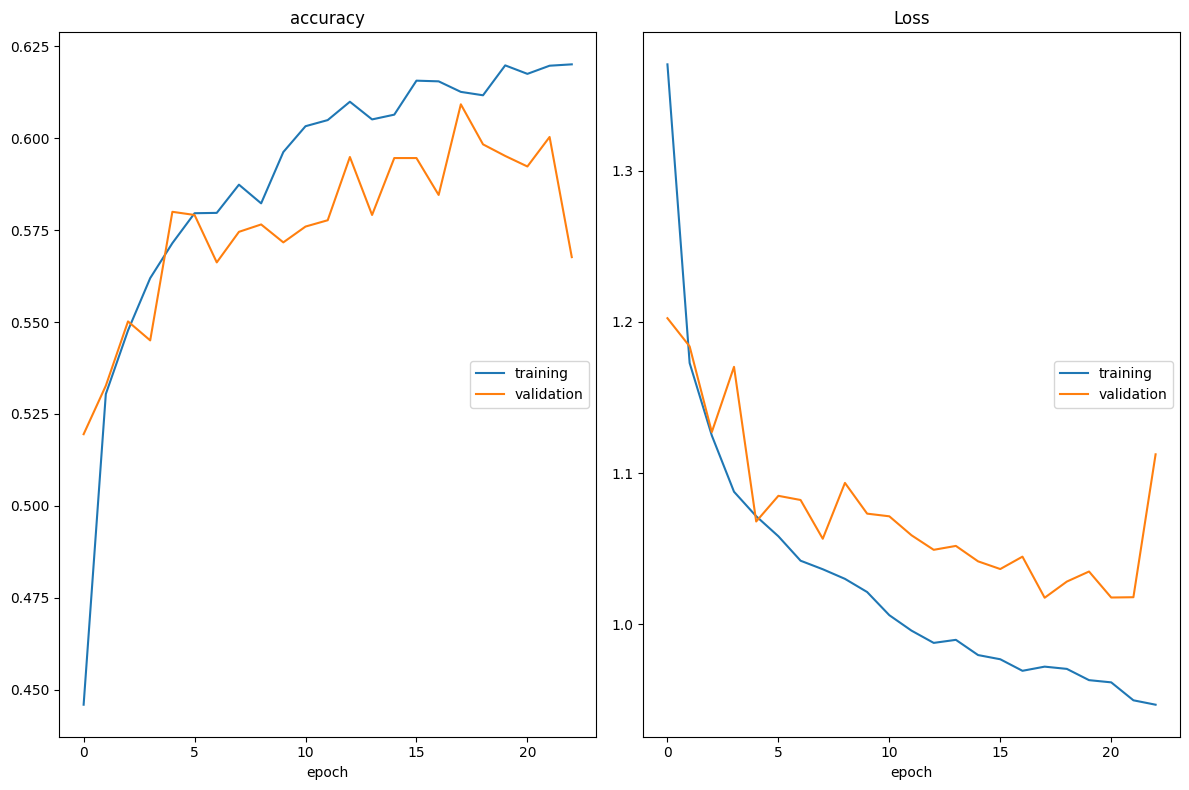

accuracy
	training         	 (min:    0.446, max:    0.620, cur:    0.620)
	validation       	 (min:    0.519, max:    0.609, cur:    0.568)
Loss
	training         	 (min:    0.947, max:    1.370, cur:    0.947)
	validation       	 (min:    1.018, max:    1.202, cur:    1.112)
338/338 ━━━━━━━━━━━━━━━━━━━━ 103s 306ms/step - accuracy: 0.6188 - loss: 0.9535 - val_accuracy: 0.5677 - val_loss: 1.1124


In [51]:
from keras.applications import DenseNet201

inputs = Input(shape=(96, 96, 3))

base_model = DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_DenseNet201.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

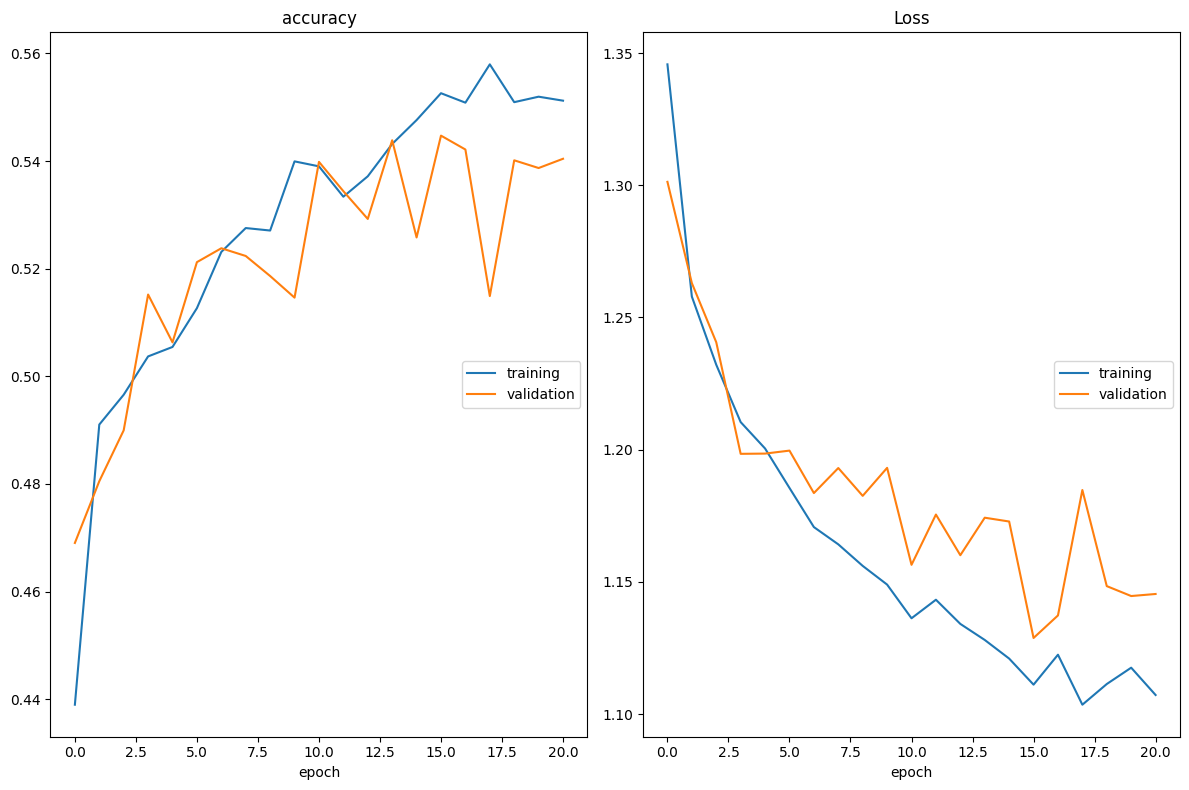

accuracy
	training         	 (min:    0.439, max:    0.558, cur:    0.551)
	validation       	 (min:    0.469, max:    0.545, cur:    0.540)
Loss
	training         	 (min:    1.104, max:    1.346, cur:    1.107)
	validation       	 (min:    1.129, max:    1.301, cur:    1.145)
338/338 ━━━━━━━━━━━━━━━━━━━━ 60s 176ms/step - accuracy: 0.5494 - loss: 1.1090 - val_accuracy: 0.5404 - val_loss: 1.1454


In [52]:
from keras.applications import Xception

inputs = Input(shape=(96, 96, 3))

base_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_Xception.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

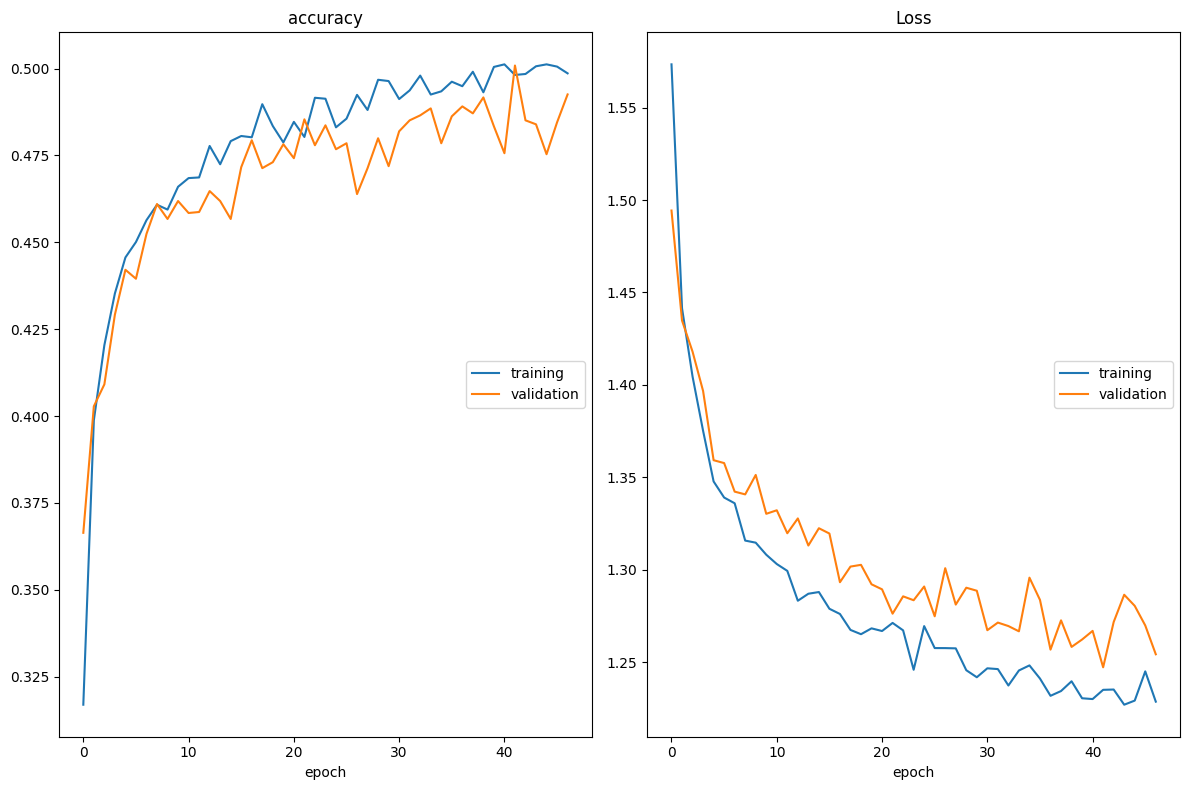

accuracy
	training         	 (min:    0.317, max:    0.501, cur:    0.499)
	validation       	 (min:    0.366, max:    0.501, cur:    0.493)
Loss
	training         	 (min:    1.227, max:    1.573, cur:    1.229)
	validation       	 (min:    1.247, max:    1.494, cur:    1.254)
338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.5024 - loss: 1.2218 - val_accuracy: 0.4925 - val_loss: 1.2542


In [53]:
from keras.applications import InceptionV3

inputs = Input(shape=(96, 96, 3))

base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model_InceptionV3.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

base_model.trainable = False


x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

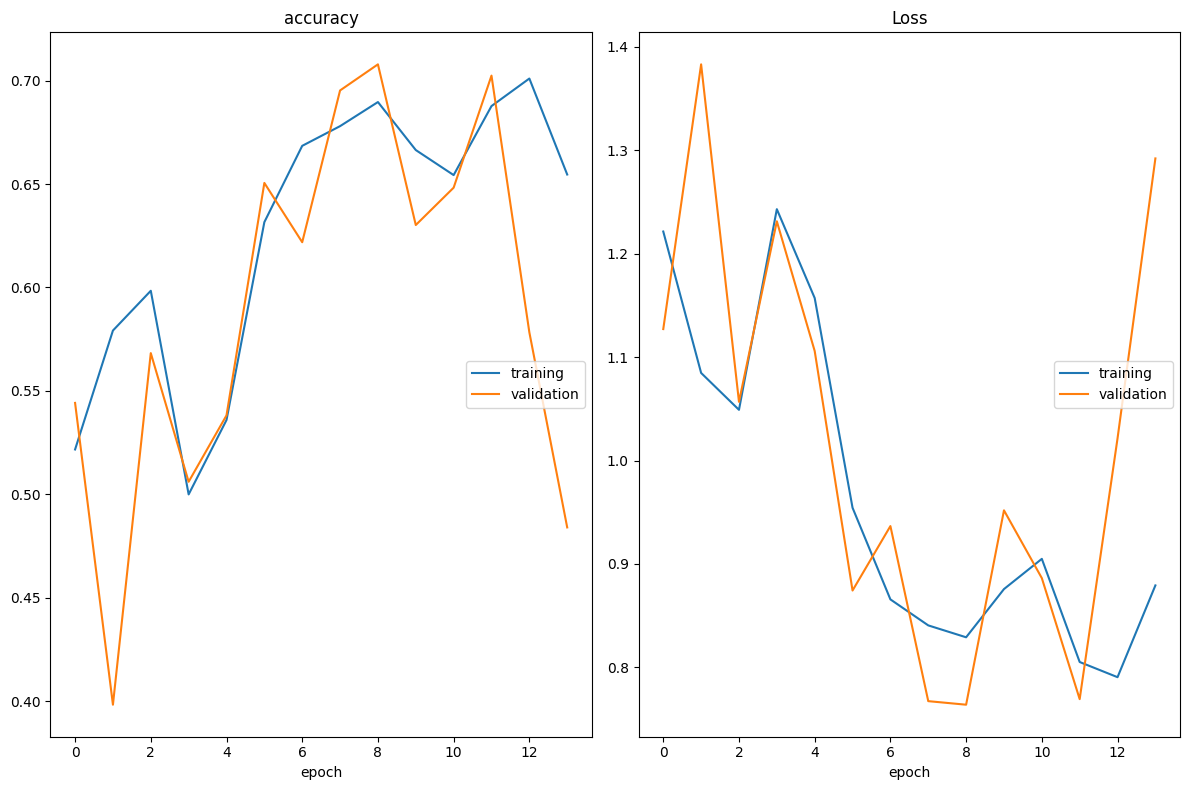

accuracy
	training         	 (min:    0.500, max:    0.701, cur:    0.655)
	validation       	 (min:    0.398, max:    0.708, cur:    0.484)
Loss
	training         	 (min:    0.791, max:    1.243, cur:    0.879)
	validation       	 (min:    0.764, max:    1.383, cur:    1.292)
338/338 ━━━━━━━━━━━━━━━━━━━━ 242s 715ms/step - accuracy: 0.6790 - loss: 0.8227 - val_accuracy: 0.4839 - val_loss: 1.2920


In [40]:
inputs = Input(shape=(96, 96, 3))

base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True, monitor="val_loss"),
    PlotLossesKerasTF()
]

for layer in base_model.layers[:-3]:
    layer.trainable = True

x = base_model(inputs)

x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(NUM_CLASSES+1, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)

# ---------------------------
# Compilar el Modelo
# ---------------------------
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------
# Entrenar con LiveLossPlot
# ---------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

In [ ]:
model.summary()

In [ ]:
val_gen =  ImageSequence(os.path.join(dataset_dir, 'valid'), label_filter=[0,4,5,6,7], return_ids=True)

test_gen = ImageSequence(os.path.join(dataset_dir, 'test'), label_filter=[0,4,5,6,7], return_ids=True)


#### Preparación del archivo de soluciones

In [55]:
sol_template = pd.read_csv('solution_template.csv')
sol_template['Target'] = None

test_gen = ImageSequence(os.path.join(dataset_dir, 'FacialExpressionDS/test'), label_filter=[0,4,5,6,7], 
                         return_ids=True, batch_size=2000, shuffle=False)

preds = []
Y = []
IDS = []
x, _, id_ = test_gen[0]
p = model.predict(x)

for i, t in zip(id_, np.argmax(p, axis=1)):
    sol_template.loc[sol_template.ID == i, 'Target'] = t

print(sol_template.Target.isnull().sum())

sol_template.to_csv('subm.csv', index=False)

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step
0
